Epoch 1/1000


C:\Users\subbu\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.4921 - loss: 0.6885 - val_accuracy: 0.2077 - val_loss: 0.7131
Epoch 2/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5020 - loss: 0.6809 - val_accuracy: 0.2093 - val_loss: 0.7212
Epoch 3/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5032 - loss: 0.6735 - val_accuracy: 0.2275 - val_loss: 0.7210
Epoch 4/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5165 - loss: 0.6662 - val_accuracy: 0.2953 - val_loss: 0.7179
Epoch 5/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5691 - loss: 0.6553 - val_accuracy: 0.3932 - val_loss: 0.7096
Epoch 6/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6309 - loss: 0.6446 - val_accuracy: 0.5026 - val_loss: 0.6925
Epoch 7/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6920 - loss: 0.6308 - val_accuracy: 0.5672 - val_loss: 0.6798
Epoch 8/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7343 - loss: 0.6150 - val_accuracy: 0.6468 - val_l

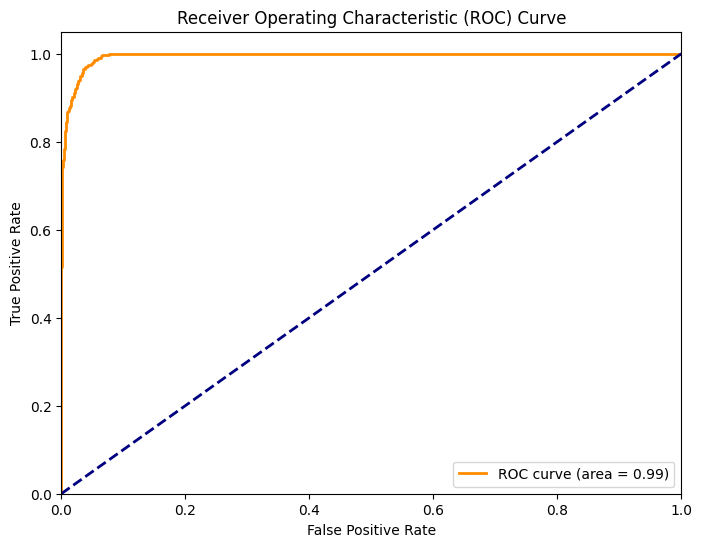

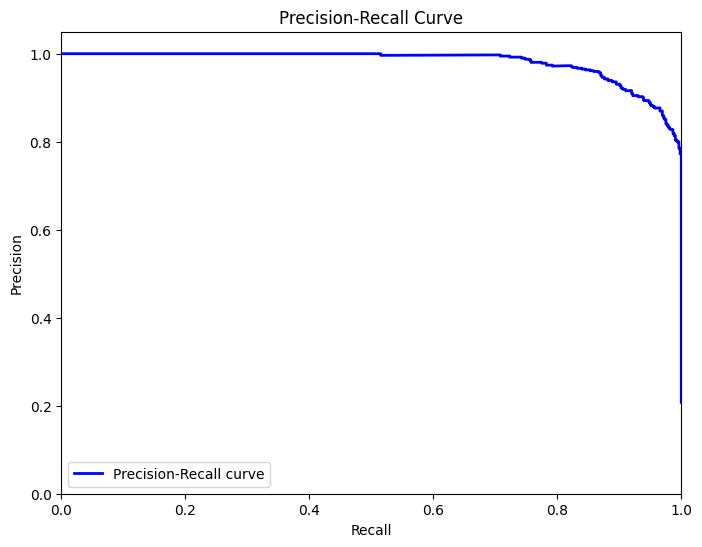

              precision    recall  f1-score   support

           0       1.00      0.94      0.97      1999
           1       0.82      0.99      0.90       524

    accuracy                           0.95      2523
   macro avg       0.91      0.97      0.93      2523
weighted avg       0.96      0.95      0.95      2523



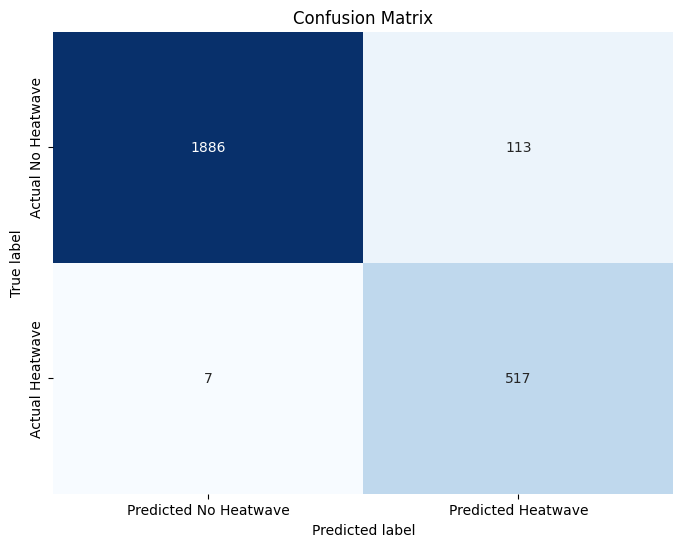

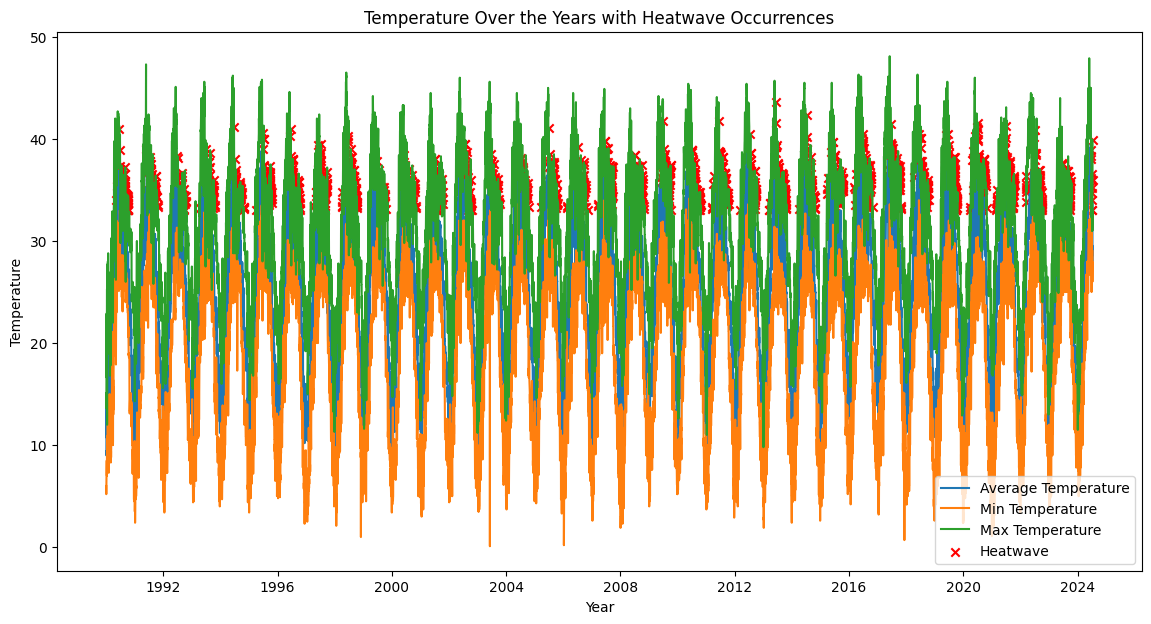

In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_recall_curve, auc, roc_curve
from sklearn.utils import class_weight
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
import seaborn as sns

# Load and preprocess data
df = pd.read_csv('hu.csv')

# Convert 'time' column to datetime with the correct format
df['time'] = pd.to_datetime(df['time'], format='%d-%m-%Y')

# Sort data by time
df = df.sort_values(by='time')

# Define thresholds for heatwave classification
threshold_temp = 33  # Threshold for high temperature for a heatwave
threshold_humid = 60  # Threshold for high humidity for a heatwave

# Define function to classify heatwave based on temperature and humidity
def classify_heatwave(row):
    if row['tmax'] >= threshold_temp and row['humid'] >= threshold_humid:
        return 1  # Heatwave due to high temperature and high humidity
    else:
        return 0  # Not a heatwave

# Apply classification function to create 'Heatwave' column
df['Heatwave'] = df.apply(classify_heatwave, axis=1)

# Handle missing values by filling with the mean of the respective columns
df.fillna(df.mean(), inplace=True)

# Prepare data for LSTM model
features = ['tavg', 'tmin', 'tmax', 'humid']  # Include 'humid' in features
X = df[features].values
y = df['Heatwave'].values

scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# Split data into training and testing sets and get the indices
X_train, X_test, y_train, y_test, train_indices, test_indices = train_test_split(X_scaled, y, df.index, test_size=0.2, random_state=42)

# Reshape input data for LSTM (samples, time steps, features)
X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

# Apply SMOTE to training data
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train.reshape(X_train.shape[0], X_train.shape[2]), y_train)

# Reshape resampled data for LSTM
X_train_resampled = X_train_resampled.reshape((X_train_resampled.shape[0], 1, X_train_resampled.shape[1]))

# Adjust class weights to handle imbalanced classes more drastically
class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(y_train_resampled), y=y_train_resampled)
class_weights_dict = dict(enumerate(class_weights))

# Define and compile the LSTM model
model = Sequential()
model.add(LSTM(50, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dense(1, activation='sigmoid'))  # Use sigmoid for binary classification

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model with class weights
history = model.fit(X_train_resampled, y_train_resampled, epochs=1000, batch_size=1000, 
                    validation_data=(X_test, y_test), class_weight=class_weights_dict,
                    callbacks=[early_stopping])

# Predict heatwave for testing data
y_test_pred_prob = model.predict(X_test)
y_test_pred = (y_test_pred_prob > 0.5).astype(int)

# Compute ROC curve and ROC area for each class
fpr, tpr, _ = roc_curve(y_test, y_test_pred_prob)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

# Compute precision-recall curve and area the curve
precision, recall, _ = precision_recall_curve(y_test, y_test_pred_prob)

# Plot precision-recall curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='blue', lw=2, label='Precision-Recall curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower left")
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.show()

# Print classification report
print(classification_report(y_test, y_test_pred))

# Confusion matrix
cm = confusion_matrix(y_test, y_test_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', cbar=False,
            xticklabels=['Predicted No Heatwave', 'Predicted Heatwave'],
            yticklabels=['Actual No Heatwave', 'Actual Heatwave'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

# Plot temperature over the years with heatwave occurrences marked
plt.figure(figsize=(14, 7))
plt.plot(df['time'], df['tavg'], label='Average Temperature')
plt.plot(df['time'], df['tmin'], label='Min Temperature')
plt.plot(df['time'], df['tmax'], label='Max Temperature')

# Mark heatwave occurrences with a cross
heatwave_dates = df[df['Heatwave'] == 1]['time']
heatwave_temps = df[df['Heatwave'] == 1]['tmax']
plt.scatter(heatwave_dates, heatwave_temps, color='red', marker='x', label='Heatwave')

plt.xlabel('Year')
plt.ylabel('Temperature')
plt.title('Temperature Over the Years with Heatwave Occurrences')
plt.legend()
plt.show()


In [16]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_recall_curve, auc, roc_curve
from sklearn.utils import class_weight
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
import seaborn as sns

# Load and preprocess data
df = pd.read_csv('hu.csv')

# Convert 'time' column to datetime with the correct format
df['time'] = pd.to_datetime(df['time'], format='%d-%m-%Y')

# Sort data by time
df = df.sort_values(by='time')

# Define thresholds for heatwave classification
threshold_temp = 33  # Threshold for high temperature for a heatwave
threshold_humid = 60  # Threshold for high humidity for a heatwave

# Define function to classify heatwave based on temperature and humidity
def classify_heatwave(row):
    if row['tmax'] >= threshold_temp and row['humid'] >= threshold_humid:
        return 1  # Heatwave due to high temperature and high humidity
    else:
        return 0  # Not a heatwave

# Apply classification function to create 'Heatwave' column
df['Heatwave'] = df.apply(classify_heatwave, axis=1)

# Handle missing values by filling with the mean of the respective columns
df.fillna(df.mean(), inplace=True)

# Prepare data for LSTM model
features = ['tavg', 'tmin', 'tmax', 'humid']  # Include 'humid' in features
X = df[features].values
y = df['Heatwave'].values

scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# Split data into training and testing sets and get the indices
X_train, X_test, y_train, y_test, train_indices, test_indices = train_test_split(X_scaled, y, df.index, test_size=0.2, random_state=42)

# Reshape input data for LSTM (samples, time steps, features)
X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

# Apply SMOTE to training data
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train.reshape(X_train.shape[0], X_train.shape[2]), y_train)

# Reshape resampled data for LSTM
X_train_resampled = X_train_resampled.reshape((X_train_resampled.shape[0], 1, X_train_resampled.shape[1]))

# Adjust class weights to handle imbalanced classes more drastically
class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(y_train_resampled), y=y_train_resampled)
class_weights_dict = dict(enumerate(class_weights))

# Define and compile the LSTM model
model = Sequential()
model.add(LSTM(50, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dense(1, activation='sigmoid'))  # Use sigmoid for binary classification

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model with class weights
history = model.fit(X_train_resampled, y_train_resampled, epochs=1000, batch_size=1000,
                    validation_data=(X_test, y_test), class_weight=class_weights_dict,
                    callbacks=[early_stopping])

def predict_heatwave(date):
    date = pd.to_datetime(date, format='%d-%m-%Y')
    if date in df['time'].values:
        row = df[df['time'] == date].iloc[0]
        print(f"On {date.date()}:")
        print(f"Maximum Temperature (tmax): {row['tmax']}")
        print(f"Minimum Temperature (tmin): {row['tmin']}")
        print(f"Humidity (humid): {row['humid']}")
        if row['Heatwave'] == 1:
            print("Heatwave: Yes")
        else:
            print("Heatwave: No")
    else:
        # Predict for future dates using the LSTM model
        date_features = df[df['time'] < date].tail(1)[features].values
        date_features_scaled = scaler.transform(date_features)
        date_features_reshaped = date_features_scaled.reshape((1, 1, date_features_scaled.shape[1]))
        prediction = model.predict(date_features_reshaped)
        if prediction > 0.5:
            print(f"On {date.date()}:")
            print(f"Predicted Maximum Temperature (tmax): {date_features[0, 2]}")
            print(f"Predicted Minimum Temperature (tmin): {date_features[0, 1]}")
            print(f"Predicted Humidity (humid): {date_features[0, 3]}")
            print("Predicted Heatwave: Yes")
        else:
            print(f"On {date.date()}:")
            print(f"Predicted Maximum Temperature (tmax): {date_features[0, 2]}")
            print(f"Predicted Minimum Temperature (tmin): {date_features[0, 1]}")
            print(f"Predicted Humidity (humid): {date_features[0, 3]}")
            print("Predicted Heatwave: No")

# Example usage:
user_date = input("Enter a date (DD-MM-YYYY): ")
predict_heatwave(user_date)


Epoch 1/1000


C:\Users\subbu\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - accuracy: 0.4125 - loss: 0.6945 - val_accuracy: 0.2077 - val_loss: 0.7123
Epoch 2/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.4995 - loss: 0.6878 - val_accuracy: 0.2077 - val_loss: 0.7205
Epoch 3/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.4906 - loss: 0.6828 - val_accuracy: 0.2077 - val_loss: 0.7259
Epoch 4/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.4975 - loss: 0.6753 - val_accuracy: 0.2172 - val_loss: 0.7271
Epoch 5/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5099 - loss: 0.6667 - val_accuracy: 0.2786 - val_loss: 0.7232
Epoch 6/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5588 - loss: 0.6568 - val_accuracy: 0.3956 - val_loss: 0.7135
Epoch 7/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6316 - loss: 0.6444 - val_accuracy: 0.4859 - val_loss: 0.6999
Epoch 8/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6847 - loss: 0.6304 - val_accuracy: 0.5731 - val_l

ValueError: time data "2026-05-05" doesn't match format "%d-%m-%Y", at position 0. You might want to try:
    - passing `format` if your strings have a consistent format;
    - passing `format='ISO8601'` if your strings are all ISO8601 but not necessarily in exactly the same format;
    - passing `format='mixed'`, and the format will be inferred for each element individually. You might want to use `dayfirst` alongside this.

In [18]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_recall_curve, auc, roc_curve
from sklearn.utils import class_weight
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
import seaborn as sns

# Load and preprocess data
df = pd.read_csv('hu.csv')

# Convert 'time' column to datetime with the correct format
df['time'] = pd.to_datetime(df['time'], format='%d-%m-%Y')

# Sort data by time
df = df.sort_values(by='time')

# Define thresholds for heatwave classification
threshold_temp = 33  # Threshold for high temperature for a heatwave
threshold_humid = 60  # Threshold for high humidity for a heatwave

# Define function to classify heatwave based on temperature and humidity
def classify_heatwave(row):
    if row['tmax'] >= threshold_temp and row['humid'] >= threshold_humid:
        return 1  # Heatwave due to high temperature and high humidity
    else:
        return 0  # Not a heatwave

# Apply classification function to create 'Heatwave' column
df['Heatwave'] = df.apply(classify_heatwave, axis=1)

# Handle missing values by filling with the mean of the respective columns
df.fillna(df.mean(), inplace=True)

# Prepare data for LSTM model
features = ['tavg', 'tmin', 'tmax', 'humid']  # Include 'humid' in features
X = df[features].values
y = df['Heatwave'].values

scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# Split data into training and testing sets and get the indices
X_train, X_test, y_train, y_test, train_indices, test_indices = train_test_split(X_scaled, y, df.index, test_size=0.2, random_state=42)

# Reshape input data for LSTM (samples, time steps, features)
X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

# Apply SMOTE to training data
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train.reshape(X_train.shape[0], X_train.shape[2]), y_train)

# Reshape resampled data for LSTM
X_train_resampled = X_train_resampled.reshape((X_train_resampled.shape[0], 1, X_train_resampled.shape[1]))

# Adjust class weights to handle imbalanced classes more drastically
class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(y_train_resampled), y=y_train_resampled)
class_weights_dict = dict(enumerate(class_weights))

# Define and compile the LSTM model
model = Sequential()
model.add(LSTM(50, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dense(1, activation='sigmoid'))  # Use sigmoid for binary classification

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model with class weights
history = model.fit(X_train_resampled, y_train_resampled, epochs=1000, batch_size=1000,
                    validation_data=(X_test, y_test), class_weight=class_weights_dict,
                    callbacks=[early_stopping])

def predict_heatwave(date):
    try:
        date = pd.to_datetime(date, format='%d-%m-%Y')
    except ValueError:
        date = pd.to_datetime(date)  # Handle date in ISO format directly
    if date in df['time'].values:
        row = df[df['time'] == date].iloc[0]
        print(f"On {date.date()}:")
        print(f"Maximum Temperature (tmax): {row['tmax']}")
        print(f"Minimum Temperature (tmin): {row['tmin']}")
        print(f"Humidity (humid): {row['humid']}")
        if row['Heatwave'] == 1:
            print("Heatwave: Yes")
        else:
            print("Heatwave: No")
    else:
        # Predict for future dates using the LSTM model
        date_features = df[df['time'] < date].tail(1)[features].values
        date_features_scaled = scaler.transform(date_features)
        date_features_reshaped = date_features_scaled.reshape((1, 1, date_features_scaled.shape[1]))
        prediction = model.predict(date_features_reshaped)
        if prediction > 0.5:
            print(f"On {date.date()}:")
            print(f"Predicted Maximum Temperature (tmax): {date_features[0, 2]}")
            print(f"Predicted Minimum Temperature (tmin): {date_features[0, 1]}")
            print(f"Predicted Humidity (humid): {date_features[0, 3]}")
            print("Predicted Heatwave: Yes")
        else:
            print(f"On {date.date()}:")
            print(f"Predicted Maximum Temperature (tmax): {date_features[0, 2]}")
            print(f"Predicted Minimum Temperature (tmin): {date_features[0, 1]}")
            print(f"Predicted Humidity (humid): {date_features[0, 3]}")
            print("Predicted Heatwave: No")

# Examp
user_date = input("Enter a date (DD-MM-YYYY or YYYY-MM-DD): ")
predict_heatwave(user_date)


Epoch 1/1000


C:\Users\subbu\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - accuracy: 0.4984 - loss: 0.6926 - val_accuracy: 0.2077 - val_loss: 0.7076
Epoch 2/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.4987 - loss: 0.6848 - val_accuracy: 0.2077 - val_loss: 0.7180
Epoch 3/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5023 - loss: 0.6772 - val_accuracy: 0.2140 - val_loss: 0.7203
Epoch 4/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5050 - loss: 0.6704 - val_accuracy: 0.2648 - val_loss: 0.7176
Epoch 5/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5460 - loss: 0.6600 - val_accuracy: 0.3583 - val_loss: 0.7118
Epoch 6/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6095 - loss: 0.6503 - val_accuracy: 0.4717 - val_loss: 0.6976
Epoch 7/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6711 - loss: 0.6369 - val_accuracy: 0.5398 - val_loss: 0.6860
Epoch 8/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7181 - loss: 0.6226 - val_accuracy: 0.6159 - val_l

In [3]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_recall_curve, auc, roc_curve
from sklearn.utils import class_weight
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
from datetime import datetime
from imblearn.over_sampling import SMOTE
import seaborn as sns

# Load and preprocess data
df = pd.read_csv('hu.csv')

# Convert 'time' column to datetime with the correct format
df['time'] = pd.to_datetime(df['time'], format='%d-%m-%Y')

# Sort data by time
df = df.sort_values(by='time')

# Define thresholds for heatwave classification
threshold_temp = 33  # Threshold for high temperature for a heatwave
threshold_humid = 60  # Threshold for high humidity for a heatwave

# Define function to classify heatwave based on temperature and humidity
def classify_heatwave(row):
    if row['tmax'] >= threshold_temp and row['humid'] >= threshold_humid:
        return 1  # Heatwave due to high temperature and high humidity
    else:
        return 0  # Not a heatwave

# Apply classification function to create 'Heatwave' column
df['Heatwave'] = df.apply(classify_heatwave, axis=1)

# Handle missing values by filling with the mean of the respective columns
df.fillna(df.mean(), inplace=True)

# Prepare data for LSTM model
features = ['tavg', 'tmin', 'tmax', 'humid']  # Include 'humid' in features
X = df[features].values
y = df['Heatwave'].values

scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# Split data into training and testing sets and get the indices
X_train, X_test, y_train, y_test, train_indices, test_indices = train_test_split(X_scaled, y, df.index, test_size=0.2, random_state=42)

# Reshape input data for LSTM (samples, time steps, features)
X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

# Apply SMOTE to training data
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train.reshape(X_train.shape[0], X_train.shape[2]), y_train)

# Reshape resampled data for LSTM
X_train_resampled = X_train_resampled.reshape((X_train_resampled.shape[0], 1, X_train_resampled.shape[1]))

# Adjust class weights to handle imbalanced classes more drastically
class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(y_train_resampled), y=y_train_resampled)
class_weights_dict = dict(enumerate(class_weights))

# Define and compile the LSTM model
model = Sequential()
model.add(LSTM(50, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dense(1, activation='sigmoid'))  # Use sigmoid for binary classification

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model with class weights
history = model.fit(X_train_resampled, y_train_resampled, epochs=1000, batch_size=1000, 
                    validation_data=(X_test, y_test), class_weight=class_weights_dict,
                    callbacks=[early_stopping])

# Function to predict heatwave for a given date based on historical data
def predict_heatwave(input_date):
    selected_data = df[df['time'] == input_date]
    if selected_data.empty:
        print(f"No data found for {input_date}. Using historical averages.")
        historical_avg_tavg = df['tavg'].mean()
        historical_avg_tmin = df['tmin'].mean()
        historical_avg_tmax = df['tmax'].mean()
        historical_avg_humid = df['humid'].mean()
        return "No Heatwave", historical_avg_tavg, historical_avg_tmin, historical_avg_tmax, historical_avg_humid
    else:
        selected_data = selected_data.iloc[0]
        prediction_prob = model.predict(np.array(selected_data[features]).reshape(1, 1, len(features)))
        prediction = (prediction_prob > 0.5).astype(int)
        return "Heatwave" if prediction == 1 else "No Heatwave", selected_data['tavg'], selected_data['tmin'], selected_data['tmax'], selected_data['humid']

# Continuous user interaction to predict heatwaves
while True:
    user_input = input("Enter a date (YYYY-MM-DD) to predict heatwave (type 'exit' to quit): ")
    if user_input.lower() == 'exit':
        break
    
    try:
        input_date = datetime.strptime(user_input, "%Y-%m-%d").date()
        prediction, avg_tavg, avg_tmin, avg_tmax, avg_humid = predict_heatwave(input_date)
        print(f"Prediction for {input_date}: {prediction}")
        print(f"Average Temperature: {avg_tavg} °C")
        print(f"Min Temperature: {avg_tmin} °C")
        print(f"Max Temperature: {avg_tmax} °C")
        print(f"Humidity: {avg_humid} %")
    except ValueError:
        print("Invalid date format. Please enter date in YYYY-MM-DD format.")


Epoch 1/1000


C:\Users\subbu\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - accuracy: 0.4803 - loss: 0.7011 - val_accuracy: 0.3397 - val_loss: 0.6984
Epoch 2/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5138 - loss: 0.6930 - val_accuracy: 0.2077 - val_loss: 0.7151
Epoch 3/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5013 - loss: 0.6865 - val_accuracy: 0.2077 - val_loss: 0.7230
Epoch 4/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5039 - loss: 0.6796 - val_accuracy: 0.2077 - val_loss: 0.7257
Epoch 5/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5018 - loss: 0.6728 - val_accuracy: 0.2243 - val_loss: 0.7219
Epoch 6/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5182 - loss: 0.6634 - val_accuracy: 0.2925 - val_loss: 0.7187
Epoch 7/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5646 - loss: 0.6553 - val_accuracy: 0.4138 - val_loss: 0.7070
Epoch 8/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6347 - loss: 0.6415 - val_accuracy: 0.4899 - val_l

Epoch 1/1000


C:\Users\subbu\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - accuracy: 0.5025 - loss: 0.6920 - val_accuracy: 0.2077 - val_loss: 0.7129
Epoch 2/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5023 - loss: 0.6851 - val_accuracy: 0.2093 - val_loss: 0.7203
Epoch 3/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5005 - loss: 0.6790 - val_accuracy: 0.2196 - val_loss: 0.7238
Epoch 4/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5156 - loss: 0.6719 - val_accuracy: 0.2961 - val_loss: 0.7201
Epoch 5/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5656 - loss: 0.6639 - val_accuracy: 0.3912 - val_loss: 0.7136
Epoch 6/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6157 - loss: 0.6534 - val_accuracy: 0.4693 - val_loss: 0.7049
Epoch 7/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6661 - loss: 0.6397 - val_accuracy: 0.5315 - val_loss: 0.6904
Epoch 8/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7149 - loss: 0.6262 - val_accuracy: 0.6092 - val_l

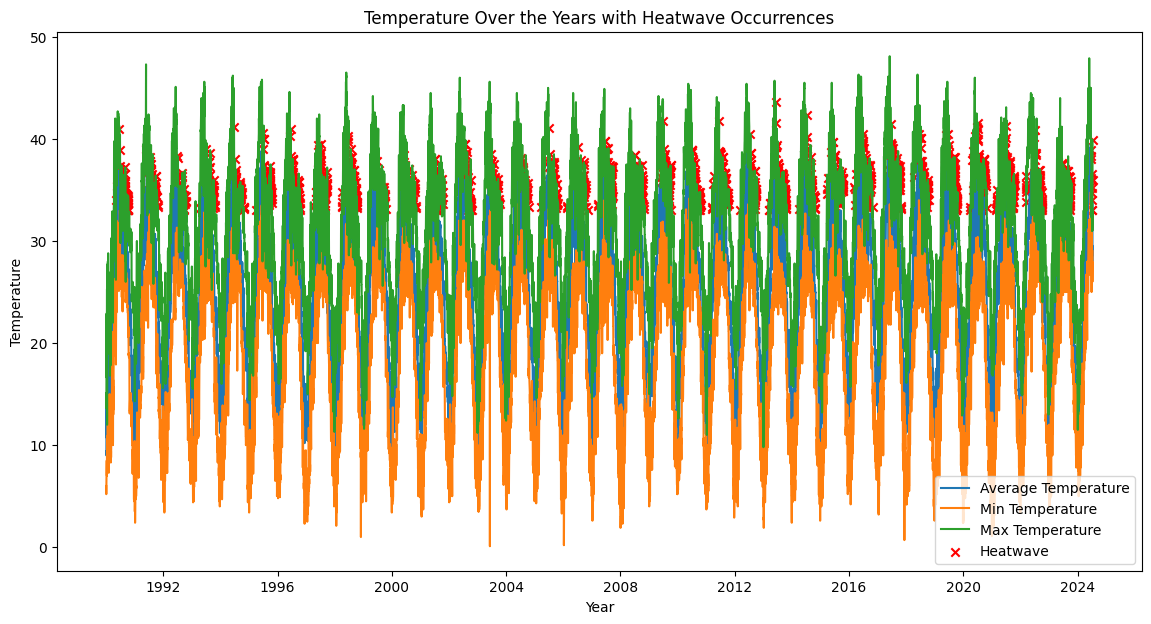

In [4]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_recall_curve, auc, roc_curve
from sklearn.utils import class_weight
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
from datetime import datetime
from imblearn.over_sampling import SMOTE
import seaborn as sns

# Load and preprocess data
df = pd.read_csv('hu.csv')

# Convert 'time' column to datetime with the correct format
df['time'] = pd.to_datetime(df['time'], format='%d-%m-%Y')

# Sort data by time
df = df.sort_values(by='time')

# Define thresholds for heatwave classification
threshold_temp = 33  # Threshold for high temperature for a heatwave
threshold_humid = 60  # Threshold for high humidity for a heatwave

# Define function to classify heatwave based on temperature and humidity
def classify_heatwave(row):
    if row['tmax'] >= threshold_temp and row['humid'] >= threshold_humid:
        return 1  # Heatwave due to high temperature and high humidity
    else:
        return 0  # Not a heatwave

# Apply classification function to create 'Heatwave' column
df['Heatwave'] = df.apply(classify_heatwave, axis=1)

# Handle missing values by filling with the mean of the respective columns
df.fillna(df.mean(), inplace=True)

# Prepare data for LSTM model
features = ['tavg', 'tmin', 'tmax', 'humid']  # Include 'humid' in features
X = df[features].values
y = df['Heatwave'].values

scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# Split data into training and testing sets and get the indices
X_train, X_test, y_train, y_test, train_indices, test_indices = train_test_split(X_scaled, y, df.index, test_size=0.2, random_state=42)

# Reshape input data for LSTM (samples, time steps, features)
X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

# Apply SMOTE to training data
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train.reshape(X_train.shape[0], X_train.shape[2]), y_train)

# Reshape resampled data for LSTM
X_train_resampled = X_train_resampled.reshape((X_train_resampled.shape[0], 1, X_train_resampled.shape[1]))

# Adjust class weights to handle imbalanced classes more drastically
class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(y_train_resampled), y=y_train_resampled)
class_weights_dict = dict(enumerate(class_weights))

# Define and compile the LSTM model
model = Sequential()
model.add(LSTM(50, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dense(1, activation='sigmoid'))  # Use sigmoid for binary classification

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model with class weights
history = model.fit(X_train_resampled, y_train_resampled, epochs=1000, batch_size=1000, 
                    validation_data=(X_test, y_test), class_weight=class_weights_dict,
                    callbacks=[early_stopping])

# Function to predict heatwave for a given date based on historical data
def predict_heatwave(input_date):
    selected_data = df[df['time'] == input_date]
    if selected_data.empty:
        print(f"No data found for {input_date}. Using historical averages.")
        historical_avg_tavg = df['tavg'].mean()
        historical_avg_tmin = df['tmin'].mean()
        historical_avg_tmax = df['tmax'].mean()
        historical_avg_humid = df['humid'].mean()
        return "No Heatwave", historical_avg_tavg, historical_avg_tmin, historical_avg_tmax, historical_avg_humid
    else:
        selected_data = selected_data.iloc[0]
        prediction_prob = model.predict(np.array(selected_data[features]).reshape(1, 1, len(features)))
        prediction = (prediction_prob > 0.5).astype(int)
        return "Heatwave" if prediction == 1 else "No Heatwave", selected_data['tavg'], selected_data['tmin'], selected_data['tmax'], selected_data['humid']

# Continuous user interaction to predict heatwaves
while True:
    user_input = input("Enter a date (YYYY-MM-DD) to predict heatwave (type 'exit' to quit): ")
    if user_input.lower() == 'exit':
        break
    
    try:
        input_date = datetime.strptime(user_input, "%Y-%m-%d").date()
        prediction, avg_tavg, avg_tmin, avg_tmax, avg_humid = predict_heatwave(input_date)
        print(f"Prediction for {input_date}: {prediction}")
        print(f"Average Temperature: {avg_tavg} °C")
        print(f"Min Temperature: {avg_tmin} °C")
        print(f"Max Temperature: {avg_tmax} °C")
        print(f"Humidity: {avg_humid} %")

        # Plot temperature over the years with heatwave occurrences marked
        plt.figure(figsize=(14, 7))
        plt.plot(df['time'], df['tavg'], label='Average Temperature')
        plt.plot(df['time'], df['tmin'], label='Min Temperature')
        plt.plot(df['time'], df['tmax'], label='Max Temperature')

        # Mark heatwave occurrences with a cross
        heatwave_dates = df[df['Heatwave'] == 1]['time']
        heatwave_temps = df[df['Heatwave'] == 1]['tmax']
        plt.scatter(heatwave_dates, heatwave_temps, color='red', marker='x', label='Heatwave')

        plt.xlabel('Year')
        plt.ylabel('Temperature')
        plt.title('Temperature Over the Years with Heatwave Occurrences')
        plt.legend()
        plt.show()

    except ValueError:
        print("Invalid date format. Please enter date in YYYY-MM-DD format.")


Epoch 1/1000


C:\Users\subbu\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - accuracy: 0.4868 - loss: 0.6972 - val_accuracy: 0.2077 - val_loss: 0.7073
Epoch 2/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.4972 - loss: 0.6884 - val_accuracy: 0.2077 - val_loss: 0.7195
Epoch 3/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5027 - loss: 0.6804 - val_accuracy: 0.2120 - val_loss: 0.7234
Epoch 4/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5103 - loss: 0.6731 - val_accuracy: 0.2838 - val_loss: 0.7192
Epoch 5/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5617 - loss: 0.6656 - val_accuracy: 0.3896 - val_loss: 0.7137
Epoch 6/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6161 - loss: 0.6562 - val_accuracy: 0.4709 - val_loss: 0.7053
Epoch 7/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6640 - loss: 0.6436 - val_accuracy: 0.5192 - val_loss: 0.6951
Epoch 8/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7079 - loss: 0.6294 - val_accuracy: 0.5929 - val_l

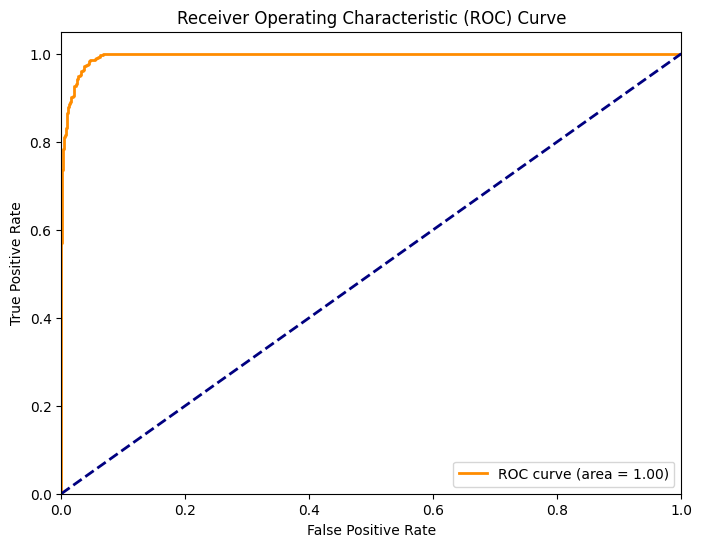

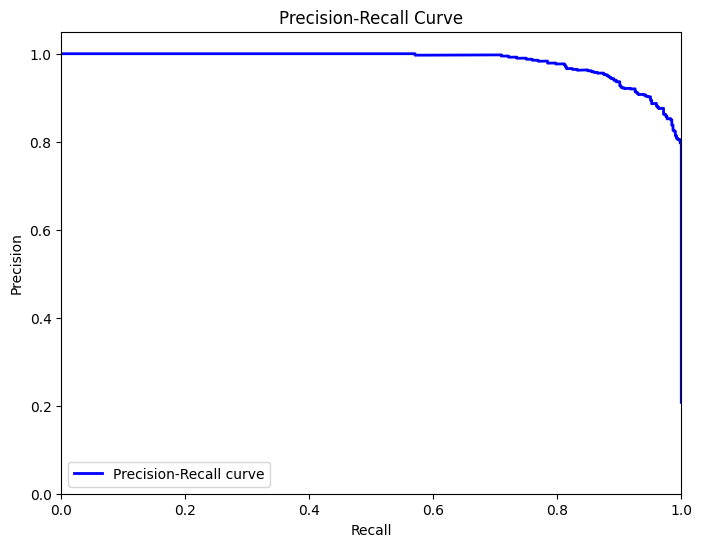

              precision    recall  f1-score   support

           0       1.00      0.95      0.97      1999
           1       0.84      0.99      0.91       524

    accuracy                           0.96      2523
   macro avg       0.92      0.97      0.94      2523
weighted avg       0.96      0.96      0.96      2523



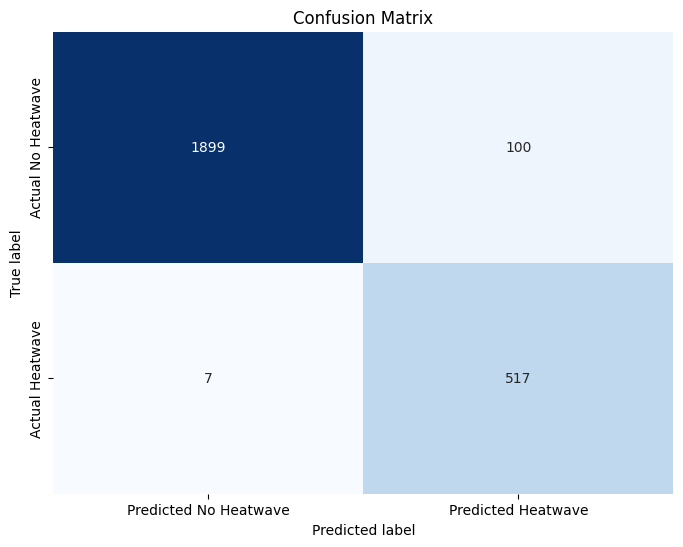

No data found for 2026-05-05. Using historical averages.
Prediction for 2026-05-05: No Heatwave
Average Temperature: 25.000190310046783 °C
Min Temperature: 19.14439774799778 °C
Max Temperature: 31.714756958211083 °C
Humidity: 60.778253628360694 %
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 938us/step


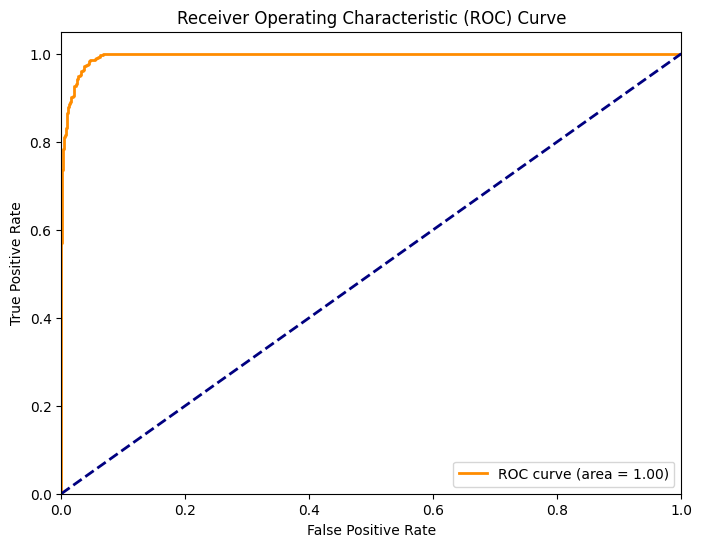

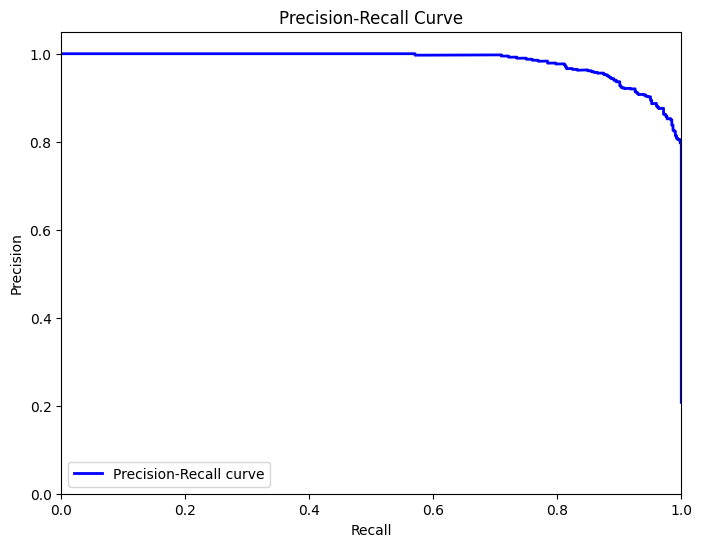

              precision    recall  f1-score   support

           0       1.00      0.95      0.97      1999
           1       0.84      0.99      0.91       524

    accuracy                           0.96      2523
   macro avg       0.92      0.97      0.94      2523
weighted avg       0.96      0.96      0.96      2523



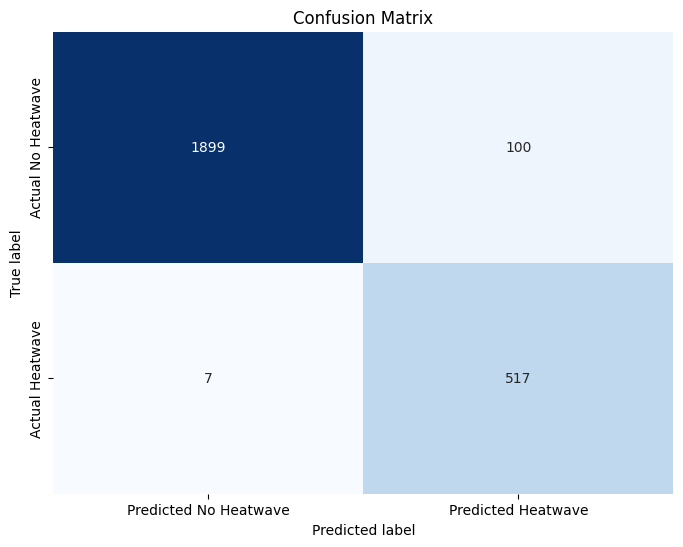

No data found for 2027-05-05. Using historical averages.
Prediction for 2027-05-05: No Heatwave
Average Temperature: 25.000190310046783 °C
Min Temperature: 19.14439774799778 °C
Max Temperature: 31.714756958211083 °C
Humidity: 60.778253628360694 %
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


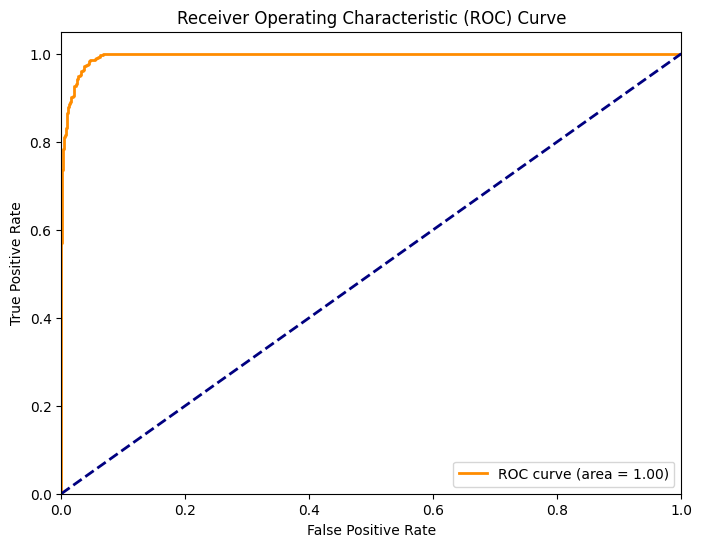

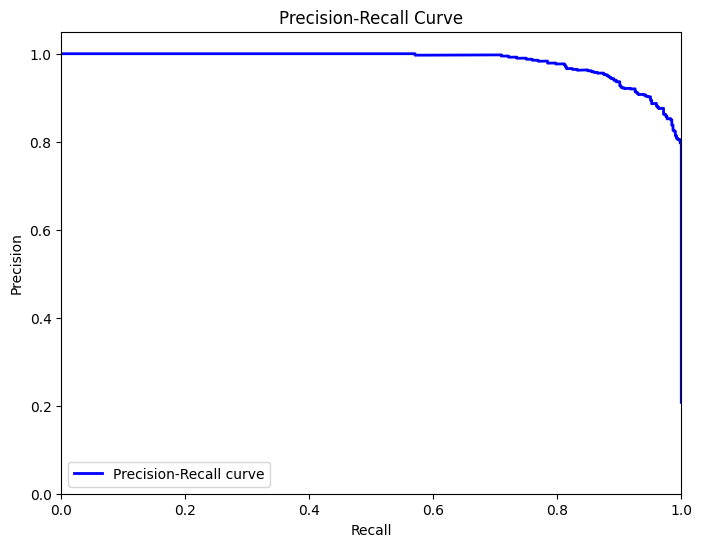

              precision    recall  f1-score   support

           0       1.00      0.95      0.97      1999
           1       0.84      0.99      0.91       524

    accuracy                           0.96      2523
   macro avg       0.92      0.97      0.94      2523
weighted avg       0.96      0.96      0.96      2523



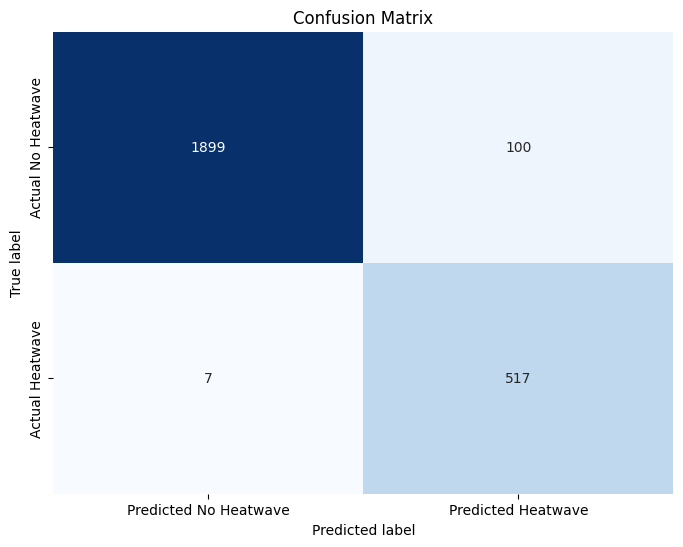

In [5]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_recall_curve, auc, roc_curve, f1_score
from sklearn.utils import class_weight
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
from datetime import datetime
from imblearn.over_sampling import SMOTE
import seaborn as sns

# Load and preprocess data
df = pd.read_csv('hu.csv')

# Convert 'time' column to datetime with the correct format
df['time'] = pd.to_datetime(df['time'], format='%d-%m-%Y')

# Sort data by time
df = df.sort_values(by='time')

# Define thresholds for heatwave classification
threshold_temp = 33  # Threshold for high temperature for a heatwave
threshold_humid = 60  # Threshold for high humidity for a heatwave

# Define function to classify heatwave based on temperature and humidity
def classify_heatwave(row):
    if row['tmax'] >= threshold_temp and row['humid'] >= threshold_humid:
        return 1  # Heatwave due to high temperature and high humidity
    else:
        return 0  # Not a heatwave

# Apply classification function to create 'Heatwave' column
df['Heatwave'] = df.apply(classify_heatwave, axis=1)

# Handle missing values by filling with the mean of the respective columns
df.fillna(df.mean(), inplace=True)

# Prepare data for LSTM model
features = ['tavg', 'tmin', 'tmax', 'humid']  # Include 'humid' in features
X = df[features].values
y = df['Heatwave'].values

scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# Split data into training and testing sets and get the indices
X_train, X_test, y_train, y_test, train_indices, test_indices = train_test_split(X_scaled, y, df.index, test_size=0.2, random_state=42)

# Reshape input data for LSTM (samples, time steps, features)
X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

# Apply SMOTE to training data
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train.reshape(X_train.shape[0], X_train.shape[2]), y_train)

# Reshape resampled data for LSTM
X_train_resampled = X_train_resampled.reshape((X_train_resampled.shape[0], 1, X_train_resampled.shape[1]))

# Adjust class weights to handle imbalanced classes more drastically
class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(y_train_resampled), y=y_train_resampled)
class_weights_dict = dict(enumerate(class_weights))

# Define and compile the LSTM model
model = Sequential()
model.add(LSTM(50, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dense(1, activation='sigmoid'))  # Use sigmoid for binary classification

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model with class weights
history = model.fit(X_train_resampled, y_train_resampled, epochs=1000, batch_size=1000, 
                    validation_data=(X_test, y_test), class_weight=class_weights_dict,
                    callbacks=[early_stopping])

# Function to predict heatwave for a given date based on historical data
def predict_heatwave(input_date):
    selected_data = df[df['time'] == input_date]
    if selected_data.empty:
        print(f"No data found for {input_date}. Using historical averages.")
        historical_avg_tavg = df['tavg'].mean()
        historical_avg_tmin = df['tmin'].mean()
        historical_avg_tmax = df['tmax'].mean()
        historical_avg_humid = df['humid'].mean()
        return "No Heatwave", historical_avg_tavg, historical_avg_tmin, historical_avg_tmax, historical_avg_humid
    else:
        selected_data = selected_data.iloc[0]
        prediction_prob = model.predict(np.array(selected_data[features]).reshape(1, 1, len(features)))
        prediction = (prediction_prob > 0.5).astype(int)
        return "Heatwave" if prediction == 1 else "No Heatwave", selected_data['tavg'], selected_data['tmin'], selected_data['tmax'], selected_data['humid']

# Continuous user interaction to predict heatwaves
while True:
    user_input = input("Enter a date (YYYY-MM-DD) to predict heatwave (type 'exit' to quit): ")
    if user_input.lower() == 'exit':
        break
    
    try:
        input_date = datetime.strptime(user_input, "%Y-%m-%d").date()
        prediction, avg_tavg, avg_tmin, avg_tmax, avg_humid = predict_heatwave(input_date)
        print(f"Prediction for {input_date}: {prediction}")
        print(f"Average Temperature: {avg_tavg} °C")
        print(f"Min Temperature: {avg_tmin} °C")
        print(f"Max Temperature: {avg_tmax} °C")
        print(f"Humidity: {avg_humid} %")

        # Compute ROC curve and ROC area for each class
        y_test_pred_prob = model.predict(X_test)
        fpr, tpr, _ = roc_curve(y_test, y_test_pred_prob)
        roc_auc = auc(fpr, tpr)

        # Plot ROC curve
        plt.figure(figsize=(8, 6))
        plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver Operating Characteristic (ROC) Curve')
        plt.legend(loc="lower right")
        plt.show()

        # Compute precision-recall curve and area the curve
        precision, recall, _ = precision_recall_curve(y_test, y_test_pred_prob)

        # Plot precision-recall curve
        plt.figure(figsize=(8, 6))
        plt.plot(recall, precision, color='blue', lw=2, label='Precision-Recall curve')
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.title('Precision-Recall Curve')
        plt.legend(loc="lower left")
        plt.ylim([0.0, 1.05])
        plt.xlim([0.0, 1.0])
        plt.show()

        # Print classification report
        y_test_pred = (y_test_pred_prob > 0.5).astype(int)
        print(classification_report(y_test, y_test_pred))

        # Confusion matrix
        cm = confusion_matrix(y_test, y_test_pred)
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', cbar=False,
                    xticklabels=['Predicted No Heatwave', 'Predicted Heatwave'],
                    yticklabels=['Actual No Heatwave', 'Actual Heatwave'])
        plt.title('Confusion Matrix')
        plt.xlabel('Predicted label')
        plt.ylabel('True label')
        plt.show()

    except ValueError:
        print("Invalid date format. Please enter date in YYYY-MM-DD format.")


Epoch 1/1000


C:\Users\subbu\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - accuracy: 0.5326 - loss: 0.6911 - val_accuracy: 0.2192 - val_loss: 0.7093
Epoch 2/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5071 - loss: 0.6836 - val_accuracy: 0.2374 - val_loss: 0.7166
Epoch 3/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5237 - loss: 0.6759 - val_accuracy: 0.2814 - val_loss: 0.7200
Epoch 4/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5573 - loss: 0.6681 - val_accuracy: 0.3702 - val_loss: 0.7167
Epoch 5/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6089 - loss: 0.6599 - val_accuracy: 0.4598 - val_loss: 0.7082
Epoch 6/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6578 - loss: 0.6488 - val_accuracy: 0.5101 - val_loss: 0.6978
Epoch 7/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6996 - loss: 0.6359 - val_accuracy: 0.5684 - val_loss: 0.6825
Epoch 8/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7317 - loss: 0.6219 - val_accuracy: 0.6163 - val_l

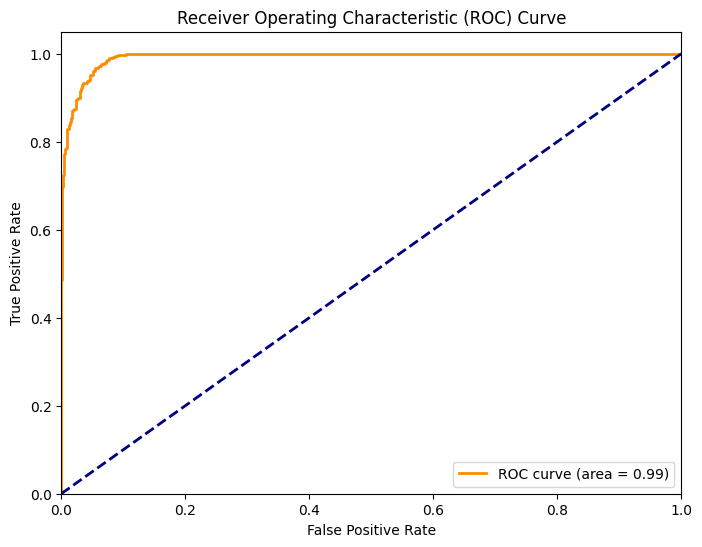

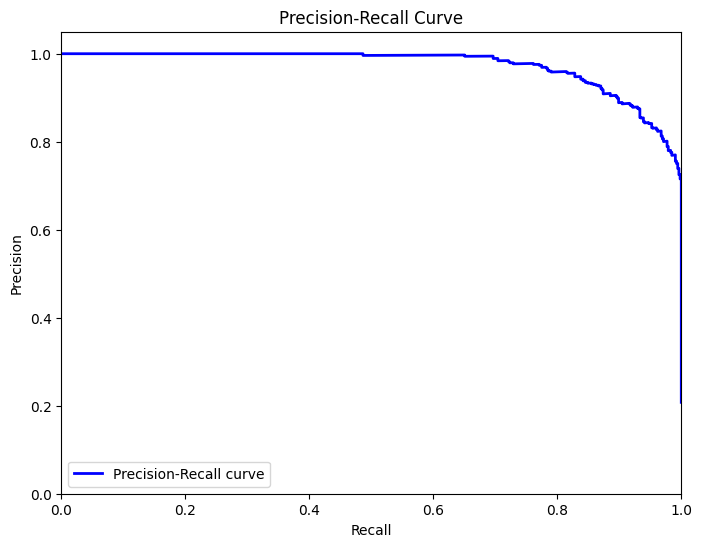

              precision    recall  f1-score   support

           0       0.99      0.93      0.96      1999
           1       0.79      0.98      0.87       524

    accuracy                           0.94      2523
   macro avg       0.89      0.95      0.92      2523
weighted avg       0.95      0.94      0.94      2523



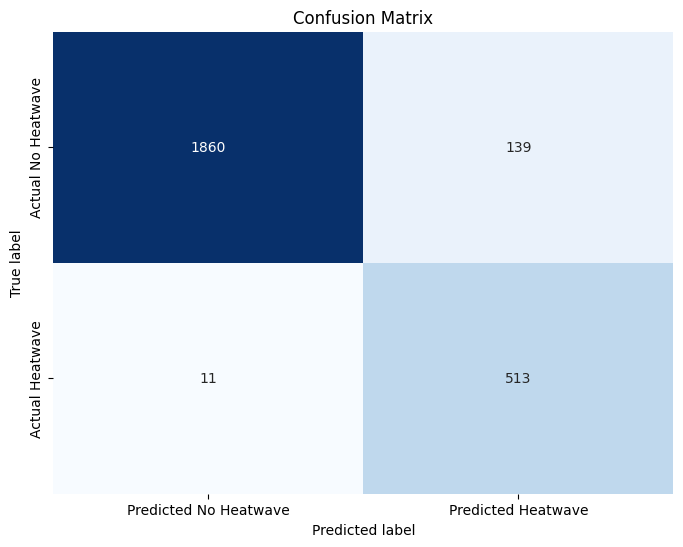

In [10]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_recall_curve, auc, roc_curve, f1_score
from sklearn.utils import class_weight
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
from datetime import datetime
from imblearn.over_sampling import SMOTE
import seaborn as sns

# Load and preprocess data
df = pd.read_csv('hu.csv')

# Convert 'time' column to datetime with the correct format
df['time'] = pd.to_datetime(df['time'], format='%d-%m-%Y')

# Sort data by time
df = df.sort_values(by='time')

# Define thresholds for heatwave classification
threshold_temp = 33  # Threshold for high temperature for a heatwave
threshold_humid = 60  # Threshold for high humidity for a heatwave

# Define function to classify heatwave based on temperature and humidity
def classify_heatwave(row):
    if row['tmax'] >= threshold_temp and row['humid'] >= threshold_humid:
        return 1  # Heatwave due to high temperature and high humidity
    else:
        return 0  # Not a heatwave

# Apply classification function to create 'Heatwave' column
df['Heatwave'] = df.apply(classify_heatwave, axis=1)

# Handle missing values by filling with the mean of the respective columns
df.fillna(df.mean(), inplace=True)

# Prepare data for LSTM model
features = ['tavg', 'tmin', 'tmax', 'humid']  # Include 'humid' in features
X = df[features].values
y = df['Heatwave'].values

scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# Split data into training and testing sets and get the indices
X_train, X_test, y_train, y_test, train_indices, test_indices = train_test_split(X_scaled, y, df.index, test_size=0.2, random_state=42)

# Reshape input data for LSTM (samples, time steps, features)
X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

# Apply SMOTE to training data
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train.reshape(X_train.shape[0], X_train.shape[2]), y_train)

# Reshape resampled data for LSTM
X_train_resampled = X_train_resampled.reshape((X_train_resampled.shape[0], 1, X_train_resampled.shape[1]))

# Adjust class weights to handle imbalanced classes more drastically
class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(y_train_resampled), y=y_train_resampled)
class_weights_dict = dict(enumerate(class_weights))

# Define and compile the LSTM model
model = Sequential()
model.add(LSTM(50, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dense(1, activation='sigmoid'))  # Use sigmoid for binary classification

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model with class weights
history = model.fit(X_train_resampled, y_train_resampled, epochs=1000, batch_size=1000, 
                    validation_data=(X_test, y_test), class_weight=class_weights_dict,
                    callbacks=[early_stopping])

# Function to predict heatwave for a given date based on historical data
def predict_heatwave(input_date):
    selected_data = df[df['time'].dt.date == input_date]
    if not selected_data.empty:
        selected_data = selected_data.iloc[0]
        prediction_prob = model.predict(np.array(selected_data[features]).reshape(1, 1, len(features)))
        prediction = (prediction_prob > 0.5).astype(int)
        return "Heatwave" if prediction == 1 else "No Heatwave", selected_data['tavg'], selected_data['tmin'], selected_data['tmax'], selected_data['humid']
    else:
        print(f"No data found for {input_date}. Using historical averages.")
        historical_avg_data = df.mean()
        return "No Heatwave", historical_avg_data['tavg'], historical_avg_data['tmin'], historical_avg_data['tmax'], historical_avg_data['humid']

# Continuous user interaction to predict heatwaves
while True:
    user_input = input("Enter a date (YYYY-MM-DD) to predict heatwave (type 'exit' to quit): ")
    if user_input.lower() == 'exit':
        break
    
    try:
        input_date = datetime.strptime(user_input, "%Y-%m-%d").date()
        prediction, avg_tavg, avg_tmin, avg_tmax, avg_humid = predict_heatwave(input_date)
        print(f"Prediction for {input_date}: {prediction}")
        print(f"Average Temperature: {avg_tavg} °C")
        print(f"Min Temperature: {avg_tmin} °C")
        print(f"Max Temperature: {avg_tmax} °C")
        print(f"Humidity: {avg_humid} %")
    except ValueError:
        print("Invalid date format. Please enter date in YYYY-MM-DD format.")

        # Compute ROC curve and ROC area for each class
y_test_pred_prob = model.predict(X_test)
fpr, tpr, _ = roc_curve(y_test, y_test_pred_prob)
roc_auc = auc(fpr, tpr)

        # Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

        # Compute precision-recall curve and area the curve
precision, recall, _ = precision_recall_curve(y_test, y_test_pred_prob)

        # Plot precision-recall curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='blue', lw=2, label='Precision-Recall curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower left")
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.show()

        # Print classification report
y_test_pred = (y_test_pred_prob > 0.5).astype(int)
print(classification_report(y_test, y_test_pred))

        # Confusion matrix
cm = confusion_matrix(y_test, y_test_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', cbar=False,
    xticklabels=['Predicted No Heatwave', 'Predicted Heatwave'],
    yticklabels=['Actual No Heatwave', 'Actual Heatwave'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

   


import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_curve, auc, roc_curve
from sklearn.utils import class_weight
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
from datetime import datetime
from imblearn.over_sampling import SMOTE
import seaborn as sns

# Load and preprocess data
df = pd.read_csv('hu.csv')

# Convert 'time' column to datetime with the correct format
df['time'] = pd.to_datetime(df['time'], format='%d-%m-%Y')

# Sort data by time
df = df.sort_values(by='time')

# Define thresholds for heatwave classification
threshold_temp = 33  # Threshold for high temperature for a heatwave
threshold_humid = 60  # Threshold for high humidity for a heatwave

# Define function to classify heatwave based on temperature and humidity
def classify_heatwave(row):
    if row['tmax'] >= threshold_temp and row['humid'] >= threshold_humid:
        return 1  # Heatwave due to high temperature and high humidity
    else:
        return 0  # Not a heatwave

# Apply classification function to create 'Heatwave' column
df['Heatwave'] = df.apply(classify_heatwave, axis=1)

# Handle missing values by filling with the mean of the respective columns
df.fillna(df.mean(), inplace=True)

# Prepare data for LSTM model
features = ['tavg', 'tmin', 'tmax', 'humid']  # Include 'humid' in features
X = df[features].values
y = df['Heatwave'].values

scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# Split data into training and testing sets and get the indices
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Apply SMOTE to training data
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Adjust class weights to handle imbalanced classes more drastically
class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(y_train_resampled), y=y_train_resampled)
class_weights_dict = dict(enumerate(class_weights))

# Define and compile the LSTM model
model = Sequential()
model.add(LSTM(50, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dense(1, activation='sigmoid'))  # Use sigmoid for binary classification

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model with class weights
history = model.fit(X_train_resampled, y_train_resampled, epochs=1000, batch_size=1000, 
                    validation_data=(X_test, y_test), class_weight=class_weights_dict,
                    callbacks=[early_stopping])

# Function to predict heatwave for a given date based on historical data or learned patterns
def predict_heatwave(input_date):
    # Check if input_date is in the dataset
    selected_data = df[df['time'].dt.date == input_date]
    
    if not selected_data.empty:
        # Date exists in the dataset, use historical data
        selected_data = selected_data.iloc[0]
        prediction_prob = model.predict(np.array(selected_data[features]).reshape(1, 1, len(features)))
        prediction = (prediction_prob > 0.5).astype(int)
        return "Heatwave" if prediction == 1 else "No Heatwave", selected_data['tavg'], selected_data['tmin'], selected_data['tmax'], selected_data['humid']
    else:
        # Date does not exist in the dataset, predict based on model
        # Prepare input features for prediction
        input_features = df[df['time'] <= input_date].tail(1)[features].values
        input_features_scaled = scaler.transform(input_features)
        
        # Reshape for LSTM input
        input_features_reshaped = input_features_scaled.reshape((1, 1, len(features)))
        
        # Predict heatwave occurrence
        prediction_prob = model.predict(input_features_reshaped)
        prediction = (prediction_prob > 0.5).astype(int)
        
        # Return prediction along with average temperature and humidity
        historical_avg_data = df[df['time'] <= input_date].mean()
        return "Heatwave" if prediction == 1 else "No Heatwave", historical_avg_data['tavg'], historical_avg_data['tmin'], historical_avg_data['tmax'], historical_avg_data['humid']

# Continuous user interaction to predict heatwaves
while True:
    user_input = input("Enter a date (YYYY-MM-DD) to predict heatwave (type 'exit' to quit): ")
    if user_input.lower() == 'exit':
        break
    
    try:
        input_date = datetime.strptime(user_input, "%Y-%m-%d").date()
        prediction, avg_tavg, avg_tmin, avg_tmax, avg_humid = predict_heatwave(input_date)
        print(f"Prediction for {input_date}: {prediction}")
        print(f"Average Temperature: {avg_tavg} °C")
        print(f"Min Temperature: {avg_tmin} °C")
        print(f"Max Temperature: {avg_tmax} °C")
        print(f"Humidity: {avg_humid} %")
    except ValueError:
        print("Invalid date format. Please enter date in YYYY-MM-DD format.")

# Evaluate model performance on test data
y_test_pred_prob = model.predict(X_test)
y_test_pred = (y_test_pred_prob > 0.5).astype(int)

# Compute and plot ROC curve
fpr, tpr, _ = roc_curve(y_test, y_test_pred_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

# Compute and plot Precision-Recall curve
precision, recall, _ = precision_recall_curve(y_test, y_test_pred_prob)

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='blue', lw=2, label='Precision-Recall curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower left")
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.show()

# Print classification report and confusion matrix
print(classification_report(y_test, y_test_pred))

cm = confusion_matrix(y_test, y_test_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', cbar=False,
            xticklabels=['Predicted No Heatwave', 'Predicted Heatwave'],
            yticklabels=['Actual No Heatwave', 'Actual Heatwave'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()


In [12]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_curve, auc, roc_curve
from sklearn.utils import class_weight
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
from datetime import datetime
from imblearn.over_sampling import SMOTE
import seaborn as sns

# Load and preprocess data
df = pd.read_csv('hu.csv')

# Convert 'time' column to datetime with the correct format
df['time'] = pd.to_datetime(df['time'], format='%d-%m-%Y')

# Sort data by time
df = df.sort_values(by='time')

# Define thresholds for heatwave classification
threshold_temp = 33  # Threshold for high temperature for a heatwave
threshold_humid = 60  # Threshold for high humidity for a heatwave

# Define function to classify heatwave based on temperature and humidity
def classify_heatwave(row):
    if row['tmax'] >= threshold_temp and row['humid'] >= threshold_humid:
        return 1  # Heatwave due to high temperature and high humidity
    else:
        return 0  # Not a heatwave

# Apply classification function to create 'Heatwave' column
df['Heatwave'] = df.apply(classify_heatwave, axis=1)

# Handle missing values by filling with the mean of the respective columns
df.fillna(df.mean(), inplace=True)

# Prepare data for LSTM model
features = ['tavg', 'tmin', 'tmax', 'humid']  # Include 'humid' in features
X = df[features].values
y = df['Heatwave'].values

scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# Split data into training and testing sets and get the indices
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Reshape input data for LSTM (samples, time steps, features)
X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))  # Adjusted reshape
X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))  # Adjusted reshape

# Apply SMOTE to training data
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train.reshape(X_train.shape[0], X_train.shape[2]), y_train)

# Reshape resampled data for LSTM
X_train_resampled = X_train_resampled.reshape((X_train_resampled.shape[0], 1, X_train_resampled.shape[1]))

# Adjust class weights to handle imbalanced classes more drastically
class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(y_train_resampled), y=y_train_resampled)
class_weights_dict = dict(enumerate(class_weights))

# Define and compile the LSTM model
model = Sequential()
model.add(LSTM(50, input_shape=(X_train.shape[1], X_train.shape[2])))  # Corrected input shape
model.add(Dense(1, activation='sigmoid'))  # Use sigmoid for binary classification

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model with class weights
history = model.fit(X_train_resampled, y_train_resampled, epochs=1000, batch_size=1000, 
                    validation_data=(X_test, y_test), class_weight=class_weights_dict,
                    callbacks=[early_stopping])

# Function to predict heatwave for a given date based on historical data or learned patterns
def predict_heatwave(input_date):
    # Check if input_date is in the dataset
    selected_data = df[df['time'].dt.date == input_date]
    
    if not selected_data.empty:
        # Date exists in the dataset, use historical data
        selected_data = selected_data.iloc[0]
        prediction_prob = model.predict(np.array(selected_data[features]).reshape(1, 1, len(features)))
        prediction = (prediction_prob > 0.5).astype(int)
        return "Heatwave" if prediction == 1 else "No Heatwave", selected_data['tavg'], selected_data['tmin'], selected_data['tmax'], selected_data['humid']
    else:
        # Date does not exist in the dataset, predict based on model
        # Prepare input features for prediction
        input_features = df[df['time'] <= input_date].tail(1)[features].values
        input_features_scaled = scaler.transform(input_features)
        
        # Reshape for LSTM input
        input_features_reshaped = input_features_scaled.reshape((1, 1, len(features)))
        
        # Predict heatwave occurrence
        prediction_prob = model.predict(input_features_reshaped)
        prediction = (prediction_prob > 0.5).astype(int)
        
        # Return prediction along with average temperature and humidity
        historical_avg_data = df[df['time'] <= input_date].mean()
        return "Heatwave" if prediction == 1 else "No Heatwave", historical_avg_data['tavg'], historical_avg_data['tmin'], historical_avg_data['tmax'], historical_avg_data['humid']

# Continuous user interaction to predict heatwaves
while True:
    user_input = input("Enter a date (YYYY-MM-DD) to predict heatwave (type 'exit' to quit): ")
    if user_input.lower() == 'exit':
        break
    
    try:
        input_date = datetime.strptime(user_input, "%Y-%m-%d").date()
        prediction, avg_tavg, avg_tmin, avg_tmax, avg_humid = predict_heatwave(input_date)
        print(f"Prediction for {input_date}: {prediction}")
        print(f"Average Temperature: {avg_tavg} °C")
        print(f"Min Temperature: {avg_tmin} °C")
        print(f"Max Temperature: {avg_tmax} °C")
        print(f"Humidity: {avg_humid} %")
    except ValueError:
        print("Invalid date format. Please enter date in YYYY-MM-DD format.")

# Evaluate model performance on test data
y_test_pred_prob = model.predict(X_test)
y_test_pred = (y_test_pred_prob > 0.5).astype(int)

# Compute and plot ROC curve
fpr, tpr, _ = roc_curve(y_test, y_test_pred_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

# Compute and plot Precision-Recall curve
precision, recall, _ = precision_recall_curve(y_test, y_test_pred_prob)

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='blue', lw=2, label='Precision-Recall curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower left")
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.show()

# Print classification report and confusion matrix
print(classification_report(y_test, y_test_pred))

cm = confusion_matrix(y_test, y_test_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', cbar=False,
            xticklabels=['Predicted No Heatwave', 'Predicted Heatwave'],
            yticklabels=['Actual No Heatwave', 'Actual Heatwave'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()


Epoch 1/1000


C:\Users\subbu\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - accuracy: 0.4575 - loss: 0.6957 - val_accuracy: 0.2077 - val_loss: 0.7083
Epoch 2/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5010 - loss: 0.6880 - val_accuracy: 0.2077 - val_loss: 0.7199
Epoch 3/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.4988 - loss: 0.6814 - val_accuracy: 0.2089 - val_loss: 0.7235
Epoch 4/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5013 - loss: 0.6742 - val_accuracy: 0.2271 - val_loss: 0.7232
Epoch 5/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5184 - loss: 0.6666 - val_accuracy: 0.3139 - val_loss: 0.7180
Epoch 6/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5730 - loss: 0.6566 - val_accuracy: 0.4114 - val_loss: 0.7104
Epoch 7/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6328 - loss: 0.6447 - val_accuracy: 0.4931 - val_loss: 0.6967
Epoch 8/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6870 - loss: 0.6306 - val_accuracy: 0.5739 - val_l

TypeError: Invalid comparison between dtype=datetime64[ns] and date

In [13]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_curve, auc, roc_curve
from sklearn.utils import class_weight
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
from datetime import datetime
from imblearn.over_sampling import SMOTE
import seaborn as sns

# Load and preprocess data
df = pd.read_csv('hu.csv')

# Convert 'time' column to datetime with the correct format
df['time'] = pd.to_datetime(df['time'], format='%d-%m-%Y')

# Sort data by time
df = df.sort_values(by='time')

# Define thresholds for heatwave classification
threshold_temp = 33  # Threshold for high temperature for a heatwave
threshold_humid = 60  # Threshold for high humidity for a heatwave

# Define function to classify heatwave based on temperature and humidity
def classify_heatwave(row):
    if row['tmax'] >= threshold_temp and row['humid'] >= threshold_humid:
        return 1  # Heatwave due to high temperature and high humidity
    else:
        return 0  # Not a heatwave

# Apply classification function to create 'Heatwave' column
df['Heatwave'] = df.apply(classify_heatwave, axis=1)

# Handle missing values by filling with the mean of the respective columns
df.fillna(df.mean(), inplace=True)

# Prepare data for LSTM model
features = ['tavg', 'tmin', 'tmax', 'humid']  # Include 'humid' in features
X = df[features].values
y = df['Heatwave'].values

scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Reshape input data for LSTM (samples, time steps, features)
X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

# Apply SMOTE to training data to handle class imbalance
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train.reshape(X_train.shape[0], X_train.shape[2]), y_train)

# Reshape resampled data for LSTM
X_train_resampled = X_train_resampled.reshape((X_train_resampled.shape[0], 1, X_train_resampled.shape[1]))

# Adjust class weights to handle imbalanced classes more drastically
class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(y_train_resampled), y=y_train_resampled)
class_weights_dict = dict(enumerate(class_weights))

# Define and compile the LSTM model
model = Sequential()
model.add(LSTM(50, input_shape=(X_train_resampled.shape[1], X_train_resampled.shape[2])))
model.add(Dense(1, activation='sigmoid'))  # Use sigmoid for binary classification
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model with class weights
history = model.fit(X_train_resampled, y_train_resampled, epochs=1000, batch_size=1000, 
                    validation_data=(X_test, y_test), class_weight=class_weights_dict,
                    callbacks=[early_stopping])

# Function to predict heatwave for a given date based on historical data or learned patterns
def predict_heatwave(input_date):
    selected_data = df[df['time'].dt.date == np.datetime64(input_date)]
    
    if not selected_data.empty:
        # Date exists in the dataset, use historical data
        selected_data = selected_data.iloc[0]
        prediction_prob = model.predict(np.array(selected_data[features]).reshape(1, 1, len(features)))
        prediction = (prediction_prob > 0.5).astype(int)
        return "Heatwave" if prediction == 1 else "No Heatwave", selected_data['tavg'], selected_data['tmin'], selected_data['tmax'], selected_data['humid']
    else:
        # Date does not exist in the dataset, predict based on model
        # Prepare input features for prediction
        input_features = df[df['time'] <= input_date].tail(1)[features].values
        input_features_scaled = scaler.transform(input_features)
        
        # Reshape for LSTM input
        input_features_reshaped = input_features_scaled.reshape((1, 1, len(features)))
        
        # Predict heatwave occurrence
        prediction_prob = model.predict(input_features_reshaped)
        prediction = (prediction_prob > 0.5).astype(int)
        
        # Return prediction along with average temperature and humidity
        historical_avg_data = df[df['time'] <= input_date].mean()
        return "Heatwave" if prediction == 1 else "No Heatwave", historical_avg_data['tavg'], historical_avg_data['tmin'], historical_avg_data['tmax'], historical_avg_data['humid']

# Continuous user interaction to predict heatwaves
while True:
    user_input = input("Enter a date (YYYY-MM-DD) to predict heatwave (type 'exit' to quit): ")
    if user_input.lower() == 'exit':
        break
    
    try:
        input_date = datetime.strptime(user_input, "%Y-%m-%d").date()
        prediction, avg_tavg, avg_tmin, avg_tmax, avg_humid = predict_heatwave(input_date)
        print(f"Prediction for {input_date}: {prediction}")
        print(f"Average Temperature: {avg_tavg:.2f} °C")
        print(f"Min Temperature: {avg_tmin:.2f} °C")
        print(f"Max Temperature: {avg_tmax:.2f} °C")
        print(f"Humidity: {avg_humid:.2f} %")
    except ValueError:
        print("Invalid date format. Please enter date in YYYY-MM-DD format.")


Epoch 1/1000


C:\Users\subbu\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - accuracy: 0.4921 - loss: 0.6929 - val_accuracy: 0.2077 - val_loss: 0.7078
Epoch 2/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5026 - loss: 0.6846 - val_accuracy: 0.2077 - val_loss: 0.7189
Epoch 3/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.4964 - loss: 0.6781 - val_accuracy: 0.2117 - val_loss: 0.7203
Epoch 4/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5054 - loss: 0.6695 - val_accuracy: 0.2517 - val_loss: 0.7177
Epoch 5/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5390 - loss: 0.6601 - val_accuracy: 0.3591 - val_loss: 0.7101
Epoch 6/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6031 - loss: 0.6496 - val_accuracy: 0.4665 - val_loss: 0.6982
Epoch 7/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6671 - loss: 0.6378 - val_accuracy: 0.5478 - val_loss: 0.6834
Epoch 8/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7203 - loss: 0.6201 - val_accuracy: 0.6151 - val_l

TypeError: Invalid comparison between dtype=datetime64[ns] and date

In [14]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_curve, auc, roc_curve
from sklearn.utils import class_weight
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
from datetime import datetime, date
from imblearn.over_sampling import SMOTE
import seaborn as sns

# Load and preprocess data
df = pd.read_csv('hu.csv')

# Convert 'time' column to datetime with the correct format
df['time'] = pd.to_datetime(df['time'], format='%d-%m-%Y')

# Sort data by time
df = df.sort_values(by='time')

# Define thresholds for heatwave classification
threshold_temp = 33  # Threshold for high temperature for a heatwave
threshold_humid = 60  # Threshold for high humidity for a heatwave

# Define function to classify heatwave based on temperature and humidity
def classify_heatwave(row):
    if row['tmax'] >= threshold_temp and row['humid'] >= threshold_humid:
        return 1  # Heatwave due to high temperature and high humidity
    else:
        return 0  # Not a heatwave

# Apply classification function to create 'Heatwave' column
df['Heatwave'] = df.apply(classify_heatwave, axis=1)

# Handle missing values by filling with the mean of the respective columns
df.fillna(df.mean(), inplace=True)

# Prepare data for LSTM model
features = ['tavg', 'tmin', 'tmax', 'humid']  # Include 'humid' in features
X = df[features].values
y = df['Heatwave'].values

scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Reshape input data for LSTM (samples, time steps, features)
X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

# Apply SMOTE to training data to handle class imbalance
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train.reshape(X_train.shape[0], X_train.shape[2]), y_train)

# Reshape resampled data for LSTM
X_train_resampled = X_train_resampled.reshape((X_train_resampled.shape[0], 1, X_train_resampled.shape[1]))

# Adjust class weights to handle imbalanced classes more drastically
class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(y_train_resampled), y=y_train_resampled)
class_weights_dict = dict(enumerate(class_weights))

# Define and compile the LSTM model
model = Sequential()
model.add(LSTM(50, input_shape=(X_train_resampled.shape[1], X_train_resampled.shape[2])))
model.add(Dense(1, activation='sigmoid'))  # Use sigmoid for binary classification
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model with class weights
history = model.fit(X_train_resampled, y_train_resampled, epochs=1000, batch_size=1000, 
                    validation_data=(X_test, y_test), class_weight=class_weights_dict,
                    callbacks=[early_stopping])

# Function to predict heatwave for a given date based on historical data or learned patterns
def predict_heatwave(input_date):
    if isinstance(input_date, date):
        input_date = pd.Timestamp(input_date)
        
    selected_data = df[df['time'].dt.date == input_date.date()]
    
    if not selected_data.empty:
        # Date exists in the dataset, use historical data
        selected_data = selected_data.iloc[0]
        prediction_prob = model.predict(np.array(selected_data[features]).reshape(1, 1, len(features)))
        prediction = (prediction_prob > 0.5).astype(int)
        return "Heatwave" if prediction == 1 else "No Heatwave", selected_data['tavg'], selected_data['tmin'], selected_data['tmax'], selected_data['humid']
    else:
        # Date does not exist in the dataset, predict based on model
        # Prepare input features for prediction
        input_features = df[df['time'] <= input_date].tail(1)[features].values
        input_features_scaled = scaler.transform(input_features)
        
        # Reshape for LSTM input
        input_features_reshaped = input_features_scaled.reshape((1, 1, len(features)))
        
        # Predict heatwave occurrence
        prediction_prob = model.predict(input_features_reshaped)
        prediction = (prediction_prob > 0.5).astype(int)
        
        # Return prediction along with average temperature and humidity
        historical_avg_data = df[df['time'] <= input_date].mean()
        return "Heatwave" if prediction == 1 else "No Heatwave", historical_avg_data['tavg'], historical_avg_data['tmin'], historical_avg_data['tmax'], historical_avg_data['humid']

# Continuous user interaction to predict heatwaves
while True:
    user_input = input("Enter a date (YYYY-MM-DD) to predict heatwave (type 'exit' to quit): ")
    if user_input.lower() == 'exit':
        break
    
    try:
        input_date = datetime.strptime(user_input, "%Y-%m-%d").date()
        prediction, avg_tavg, avg_tmin, avg_tmax, avg_humid = predict_heatwave(input_date)
        print(f"Prediction for {input_date}: {prediction}")
        print(f"Average Temperature: {avg_tavg:.2f} °C")
        print(f"Min Temperature: {avg_tmin:.2f} °C")
        print(f"Max Temperature: {avg_tmax:.2f} °C")
        print(f"Humidity: {avg_humid:.2f} %")
    except ValueError:
        print("Invalid date format. Please enter date in YYYY-MM-DD format.")


Epoch 1/1000


C:\Users\subbu\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - accuracy: 0.5124 - loss: 0.6933 - val_accuracy: 0.2866 - val_loss: 0.7058
Epoch 2/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5245 - loss: 0.6855 - val_accuracy: 0.2350 - val_loss: 0.7163
Epoch 3/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5221 - loss: 0.6776 - val_accuracy: 0.2751 - val_loss: 0.7204
Epoch 4/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5600 - loss: 0.6702 - val_accuracy: 0.3627 - val_loss: 0.7178
Epoch 5/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6019 - loss: 0.6621 - val_accuracy: 0.4546 - val_loss: 0.7097
Epoch 6/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6526 - loss: 0.6503 - val_accuracy: 0.5018 - val_loss: 0.7020
Epoch 7/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6905 - loss: 0.6384 - val_accuracy: 0.5585 - val_loss: 0.6874
Epoch 8/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7263 - loss: 0.6244 - val_accuracy: 0.6223 - val_l

In [15]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_curve, auc, roc_curve
from sklearn.utils import class_weight
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
from datetime import datetime, date
from imblearn.over_sampling import SMOTE
import seaborn as sns

# Load and preprocess data
df = pd.read_csv('hu.csv')

# Convert 'time' column to datetime with the correct format
df['time'] = pd.to_datetime(df['time'], format='%d-%m-%Y')

# Sort data by time
df = df.sort_values(by='time')

# Define thresholds for heatwave classification
threshold_temp = 33  # Threshold for high temperature for a heatwave
threshold_humid = 60  # Threshold for high humidity for a heatwave

# Define function to classify heatwave based on temperature and humidity
def classify_heatwave(row):
    if row['tmax'] >= threshold_temp and row['humid'] >= threshold_humid:
        return 1  # Heatwave due to high temperature and high humidity
    else:
        return 0  # Not a heatwave

# Apply classification function to create 'Heatwave' column
df['Heatwave'] = df.apply(classify_heatwave, axis=1)

# Handle missing values by filling with the mean of the respective columns
df.fillna(df.mean(), inplace=True)

# Prepare data for LSTM model
features = ['tavg', 'tmin', 'tmax', 'humid']  # Include 'humid' in features
X = df[features].values
y = df['Heatwave'].values

scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Reshape input data for LSTM (samples, time steps, features)
X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

# Apply SMOTE to training data to handle class imbalance
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train.reshape(X_train.shape[0], X_train.shape[2]), y_train)

# Reshape resampled data for LSTM
X_train_resampled = X_train_resampled.reshape((X_train_resampled.shape[0], 1, X_train_resampled.shape[1]))

# Adjust class weights to handle imbalanced classes more drastically
class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(y_train_resampled), y=y_train_resampled)
class_weights_dict = dict(enumerate(class_weights))

# Define and compile the LSTM model
model = Sequential()
model.add(LSTM(50, input_shape=(X_train_resampled.shape[1], X_train_resampled.shape[2])))
model.add(Dense(1, activation='sigmoid'))  # Use sigmoid for binary classification
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model with class weights
history = model.fit(X_train_resampled, y_train_resampled, epochs=1000, batch_size=1000, 
                    validation_data=(X_test, y_test), class_weight=class_weights_dict,
                    callbacks=[early_stopping])

# Function to predict heatwave for a given date based on historical data or learned patterns
def predict_heatwave(input_date):
    if isinstance(input_date, date):
        input_date = pd.Timestamp(input_date)
        
    selected_data = df[df['time'].dt.date == input_date.date()]
    
    if not selected_data.empty:
        # Date exists in the dataset, use historical data
        selected_data = selected_data.iloc[0]
        return selected_data['Heatwave'], selected_data['tavg'], selected_data['tmin'], selected_data['tmax'], selected_data['humid']
    else:
        # Date does not exist in the dataset, predict based on model
        # Prepare input features for prediction
        input_features = df[df['time'] <= input_date].tail(1)[features].values
        input_features_scaled = scaler.transform(input_features)
        
        # Reshape for LSTM input
        input_features_reshaped = input_features_scaled.reshape((1, 1, len(features)))
        
        # Predict heatwave occurrence
        prediction_prob = model.predict(input_features_reshaped)
        prediction = (prediction_prob > 0.5).astype(int)
        
        # Return prediction along with average temperature and humidity
        historical_avg_data = df[df['time'] <= input_date].mean()
        return prediction[0, 0], historical_avg_data['tavg'], historical_avg_data['tmin'], historical_avg_data['tmax'], historical_avg_data['humid']

# Continuous user interaction to predict heatwaves
while True:
    user_input = input("Enter a date (YYYY-MM-DD) to predict heatwave (type 'exit' to quit): ")
    if user_input.lower() == 'exit':
        break
    
    try:
        input_date = datetime.strptime(user_input, "%Y-%m-%d").date()
        prediction, avg_tavg, avg_tmin, avg_tmax, avg_humid = predict_heatwave(input_date)
        if isinstance(prediction, int):
            print(f"Prediction for {input_date}: {'Heatwave' if prediction == 1 else 'No Heatwave'}")
            print(f"Average Temperature: {avg_tavg:.2f} °C")
            print(f"Min Temperature: {avg_tmin:.2f} °C")
            print(f"Max Temperature: {avg_tmax:.2f} °C")
            print(f"Humidity: {avg_humid:.2f} %")
        else:
            print("No data found for this date. Please try another date.")
    except ValueError:
        print("Invalid date format. Please enter date in YYYY-MM-DD format.")


Epoch 1/1000


C:\Users\subbu\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.4509 - loss: 0.6957 - val_accuracy: 0.2077 - val_loss: 0.7082
Epoch 2/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5024 - loss: 0.6881 - val_accuracy: 0.2077 - val_loss: 0.7169
Epoch 3/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.4953 - loss: 0.6824 - val_accuracy: 0.2077 - val_loss: 0.7203
Epoch 4/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5039 - loss: 0.6747 - val_accuracy: 0.2196 - val_loss: 0.7211
Epoch 5/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5083 - loss: 0.6681 - val_accuracy: 0.2866 - val_loss: 0.7173
Epoch 6/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5622 - loss: 0.6572 - val_accuracy: 0.3757 - val_loss: 0.7113
Epoch 7/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6196 - loss: 0.6475 - val_accuracy: 0.4859 - val_loss: 0.6964
Epoch 8/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6809 - loss: 0.6341 - val_accuracy: 0.5632 - val_l